In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import sys

In [2]:
import tools as tl

In [3]:
print(sys.version)
print(np.__version__)
print(cv2.__version__)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
1.19.2
4.0.1


# Init function

In [20]:
def get_gradient(gray, x = 0, y = 0, useGradient = True):
    if useGradient:
        grad = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=x, dy=y, ksize=3)

        '''
            take absolute value of gradient to use negative gradient
        '''
        grad = np.absolute(grad)

        '''
            Normalization of gradient
        '''
        (minVal, maxVal) = (np.min(grad), np.max(grad)) 
        if maxVal - minVal > 0:
            grad = (255 * ((grad - minVal) / float(maxVal - minVal))).astype("uint8")
        else:
            grad  = np.zeros(gray.shape, dtype = "uint8")

    else:
        grad = cv2.adaptiveThreshold(  gray,
                                        255,
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV,
                                        11,
                                        2)

    return grad

def image_plot(img, size = (10,10), title = ''):
    fig, ax = plt.subplots(figsize=(w, h))
    plt.title(text)
    ax.imshow(img, cmap='gray')
    plt.show()
    
def image_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Process image

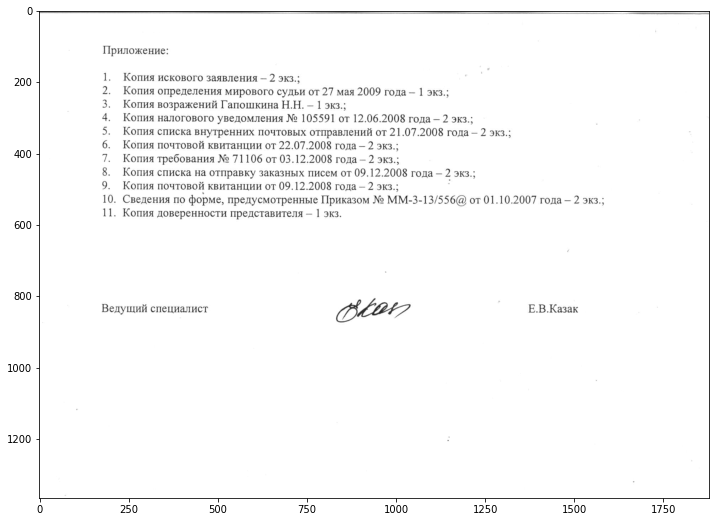

In [18]:
vis = cv2.imread('11.jpg')
img = image_to_gray(vis)
image_plot(img)

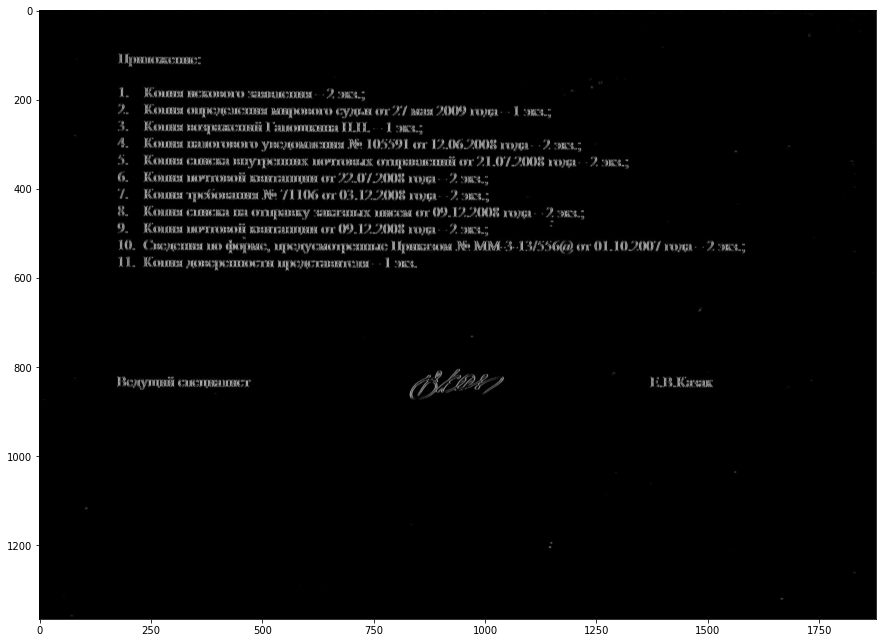

In [84]:
bin_img = get_gradient(img, x = 1, useGradient = True)
image_plot(bin_img, 15, 15)

0.06666666666666667


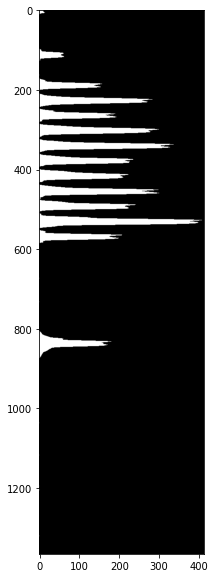

In [85]:
verp = np.sum(bin_img, axis=1) / 255
print(verp[1200])
drawedverp = tl.getDrawProjectionVer(img, verp)
image_plot(drawedverp)

## Find filter size

In [86]:
half = int(np.max(verp) / 2)
print(half)
sliceLine = drawedverp[:,(half-1):(half+1)]
contours, hierarchy = cv2.findContours(cv2.cvtColor(   sliceLine, 
                                                       cv2.COLOR_BGR2GRAY), 
                                                       cv2.RETR_EXTERNAL, 
                                                       cv2.CHAIN_APPROX_SIMPLE)
print(len(sliceLine))

204
1366


In [87]:
heights = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    heights.append(h)

In [88]:
medianHeight = int(np.median(np.asarray(heights)) * 1.5)
print("medianHeight", medianHeight)

medianHeight 18


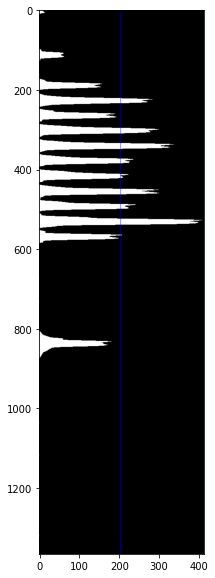

In [89]:
drawedverp = cv2.line(drawedverp, 
                      (half,0), 
                      (half,drawedverp.shape[0]), 
                      (0,0,255), 
                      1)
image_plot(drawedverp)

## Convolve peaks

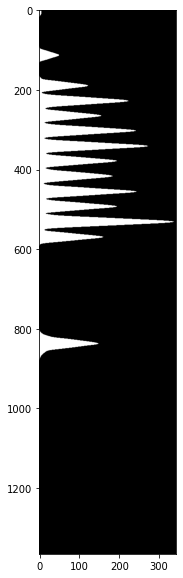

In [90]:
kernel = medianHeight
verpConvolved = np.convolve(verp, np.ones((kernel,))/kernel, mode='same')
drawedverpconv = tl.getDrawProjectionVer(img, verpConvolved)
image_plot(drawedverpconv)

## Find peaks

In [91]:
bandP1ranges = []
peaks = []
c1 = 0.2
c2 = 0.4
while np.max(verpConvolved) > 40:
    ybm = np.argmax(verpConvolved)

    yb0 = tl.findb0(verpConvolved, 
                    ybm, 
                    c1 * verpConvolved[ybm])
    yb1 = tl.findb1(verpConvolved, 
                    ybm, 
                    c2 * verpConvolved[ybm])

    if yb1 - yb0 > medianHeight:
        bandP1ranges.append((yb0,yb1))
        peaks.append((int(verpConvolved[ybm]), ybm))

    verpConvolved[yb0:yb1] = 0

In [92]:
# draw peaks
for peak in peaks:
    cv2.circle(drawedverpconv, peak, 5, (255,0,0), -1)

In [93]:
# draw bands
bandsImg = np.zeros(vis.shape, dtype = np.uint8)
for band in bandP1ranges:
    yt, yb = band
    bandsImg[yt:yb] = [125,125,0]

In [94]:
vis = cv2.addWeighted(vis, 0.6, bandsImg, 0.4, 0)

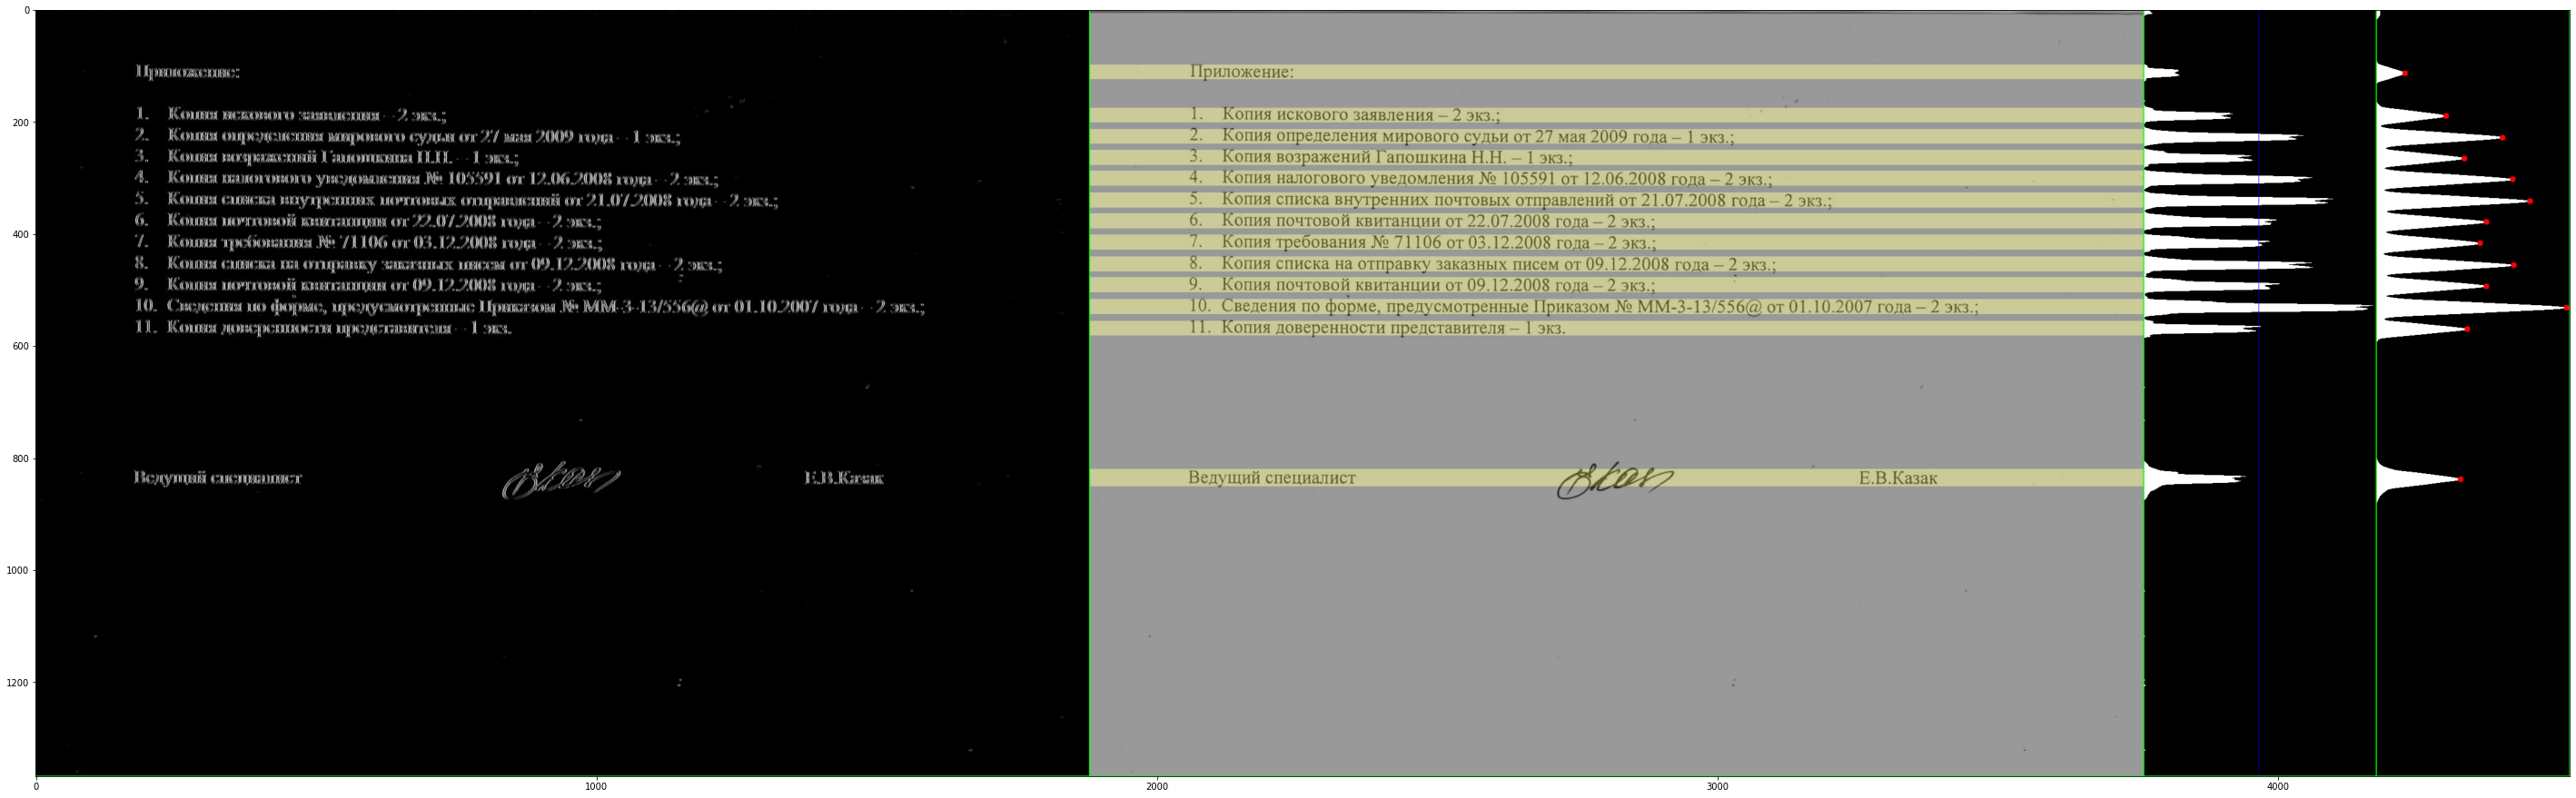

In [95]:
bigImg1 = tl.concat_hor((bin_img,vis, drawedverp, drawedverpconv))
image_plot(bigImg1,50,50)